In [12]:
from trainer.trainer import treeTrainer
from agent.agent import debugTreeAgent
from env.env import debugTreeEnv

import numpy as np
import matplotlib.pyplot as plt

pop = 20
max_gen = 200
env = debugTreeEnv(pop, max_gen)
agent = debugTreeAgent(actor_hiddens=[256]*4, critic_hiddens=[256]*4, actor_lr=1E-4, critic_lr=2E-4)
T = treeTrainer(env, agent, gamma=0.995)
T.env.propagator.k = 1.
# T.agent.load("../model/check_point3.ptd")

In [13]:
T.tree.explore_eps = 0.5
T.train(n_episode=4)

Output()

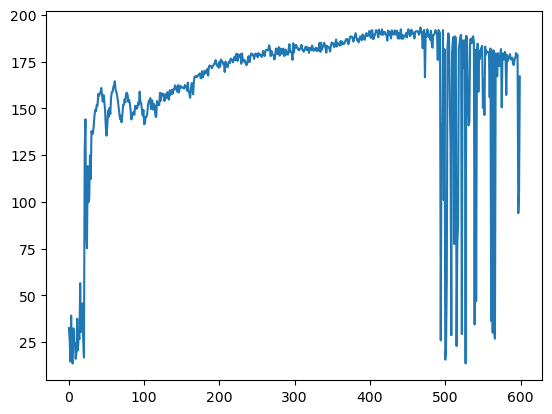

In [6]:
import numpy as np
import matplotlib.pyplot as plt
log = np.load("../model/log.npz")
plt.close("all")
plt.plot(log["true_values"])
# plt.yscale("log")
plt.show()
log.close()

In [7]:
import torch
import numpy as np
ds = T.simulate()
d = ds[0]
values = T.agent.critic(torch.from_numpy(d["obss"]).to(T.agent.device))
values = values.detach().cpu().numpy()

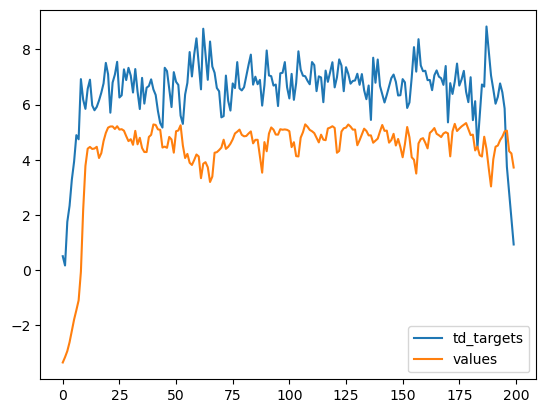

In [8]:
plt.close("all")
plt.plot(d["td_targets"], label="td_targets")
plt.plot(values, label="values")
plt.legend()
plt.show()

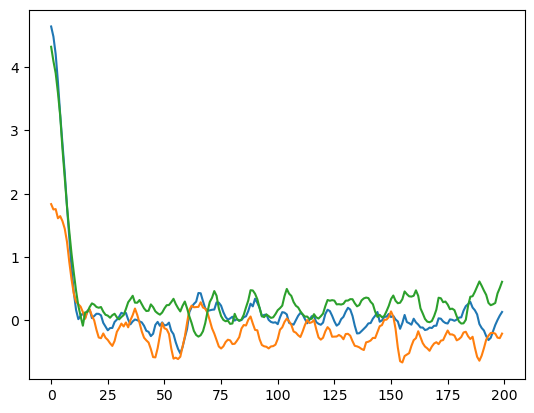

In [9]:
plt.close("all")
# d = ds[1]
d2o = np.linalg.norm(d["states"][:,:3], axis=1)
for i in range(3):
    plt.plot(d["states"][:,i])
plt.show()

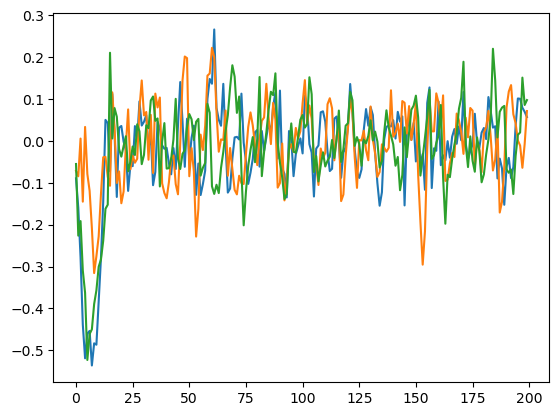

In [10]:
plt.close("all")
# d = ds[1]
d2o = np.linalg.norm(d["states"][:,:3], axis=1)
for i in range(3,6):
    plt.plot(d["states"][:,i])
plt.show()

In [1]:
from trainer.trainer import singleTrainer
from agent.agent import PPOClipAgent
from env.env import debugSingleEnv

import numpy as np
import matplotlib.pyplot as plt

env = debugSingleEnv(200)
agent = PPOClipAgent(actor_hiddens=[256]*4, critic_hiddens=[256]*4, actor_lr=1E-4, critic_lr=2E-3)
T = singleTrainer(env, agent)

In [ ]:
T.train(n_sim=100)

In [126]:
from trainer.trainer import treeTrainer
from agent.agent import debugTreeAgent
from env.env import debugTreeEnv

import numpy as np
import matplotlib.pyplot as plt

pop = 200
max_gen = 500
env = debugTreeEnv(pop, max_gen, A=True)
agent = debugTreeAgent(actor_hiddens=[256]*4, critic_hiddens=[256]*4, actor_lr=1E-4, critic_lr=2E-4)
T = treeTrainer(env, agent, gamma=0.995)
T.agent.load("../model/check_point3.ptd")

In [12]:
_ = T.test(t_max=0.05, pick_mode="td_target")
print(T.tree.gen)
print(T.testEnv.episode)

7
201


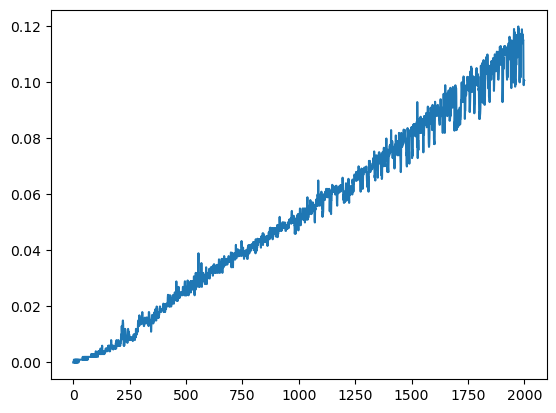

In [128]:
import time
import torch
import matplotlib.pyplot as plt
T.reset_env()
done = False
times = []
for g in range(T.tree.max_gen):
    t0 = time.time()
    for i in range(T.tree.population):
        if g>0:
            T.tree.nodes[g,i].attach(T.tree.nodes[g-1,i])
        else: # gen == 0
            # T.tree.nodes[g,i].attach(T.tree.root)
            pass
    t1 = time.time()
    times.append(t1-t0)
plt.plot(times)
plt.show()

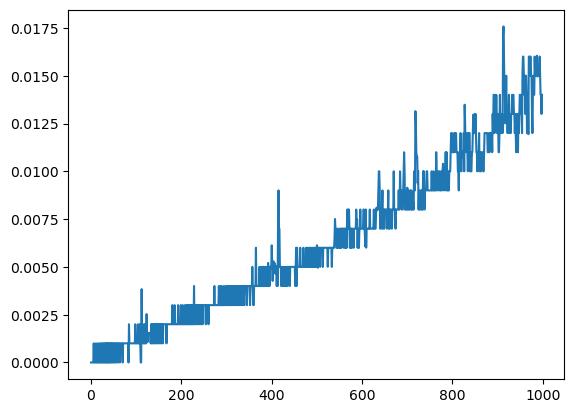

In [155]:
import anytree
import time
max_gen = 1000
pop = 80
nodes = np.empty((max_gen,pop), dtype=object)
times = []
for i in range(max_gen):
    for j in range(pop):
        nodes[i][j] = anytree.Node(f"{i},{j}")
for i in range(1,max_gen):
    t0 = time.time()
    for j in range(pop):
        nodes[i][j].parent = nodes[i-1][j]
    t1 = time.time()
    times.append(t1 - t0)
plt.plot(times)
plt.show()